# Part 1 — Sensitivity of Logistic Fit to Point Removal

In this section, we evaluate how the removal of individual data points affects 
the quality of a logistic fit. We divide the x-axis into intervals and perform 
Monte Carlo simulations where each point is removed once, the sigmoid is refit, 
and the change in MSE is recorded.

This allows us to identify which regions of the logistic curve (e.g. asymptotes 
vs. inflection zone) contribute the most to the stability of the fit.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import pandas as pd


# ---------------------------------------------------------------------
# Logistic function definition
# ---------------------------------------------------------------------
def logistic_function(x, L, k, x0):
    """
    Standard 3-parameter logistic (sigmoid) function.

    y(x) = L / (1 + exp(-k * (x - x0)))
    """
    return L / (1 + np.exp(-k * (x - x0)))


# ---------------------------------------------------------------------
# 1. Point-removal sensitivity analysis
# ---------------------------------------------------------------------
def analyze_point_removal(
    n_points,
    runs=50,
    L_true=10.0,
    k_true=1.0,
    x0_true=5.0,
    noise_level=0.5,
    x_min=0.0,
    x_max=10.0,
    interval_width=1.0,
):
    """
    Analyze the impact of removing individual points in different x-intervals
    on the quality of a logistic fit.

    Parameters
    ----------
    n_points : int
        Number of data points in each simulated dataset.
    runs : int
        Number of Monte Carlo runs.
    L_true, k_true, x0_true : float
        True parameters of the logistic function used to generate the data.
    noise_level : float
        Standard deviation of the additive Gaussian noise.
    x_min, x_max : float
        Range of x-values.
    interval_width : float
        Width of the x-intervals used to group points.

    Returns
    -------
    all_impacts : np.ndarray
        Array of shape (runs, n_intervals) containing the average MSE impact
        (per removed point) for each interval and each run.
    intervals : np.ndarray
        Array of interval boundaries (length n_intervals + 1).
    """
    # Define interval boundaries (e.g., 0, 1, 2, ..., 10)
    intervals = np.arange(x_min, x_max + interval_width, interval_width)
    n_intervals = len(intervals) - 1

    all_impacts = []

    for _ in range(runs):
        # Generate x and noisy logistic data
        x_values = np.linspace(x_min, x_max, n_points)
        y_true = logistic_function(x_values, L_true, k_true, x0_true)
        y_values = y_true + noise_level * np.random.normal(size=n_points)

        # Baseline fit using all points
        popt_initial, _ = curve_fit(
            logistic_function, x_values, y_values, p0=[L_true, k_true, x0_true], maxfev=5000
        )
        y_fit_initial = logistic_function(x_values, *popt_initial)
        baseline_mse = mean_squared_error(y_true, y_fit_initial)

        impacts = np.zeros(n_intervals)
        counts = np.zeros(n_intervals)  # number of successful removals per interval

        # Iterate over intervals
        for i in range(n_intervals):
            lower, upper = intervals[i], intervals[i + 1]

            # Use half-open intervals [lower, upper) except for the last one (closed on the right)
            if i < n_intervals - 1:
                mask = (x_values >= lower) & (x_values < upper)
            else:
                mask = (x_values >= lower) & (x_values <= upper)

            if not np.any(mask):
                continue

            # Indices of points in this interval
            indices_in_interval = np.where(mask)[0]

            # Try removing each point in the interval
            for idx in indices_in_interval:
                mask_global = np.ones(n_points, dtype=bool)
                mask_global[idx] = False

                x_removed = x_values[mask_global]
                y_removed = y_values[mask_global]

                # Fit new model without the removed point
                try:
                    popt_modified, _ = curve_fit(
                        logistic_function,
                        x_removed,
                        y_removed,
                        p0=[L_true, k_true, x0_true],
                        maxfev=5000,
                    )
                    y_fit_modified = logistic_function(x_values, *popt_modified)
                    mse_modified = mean_squared_error(y_true, y_fit_modified)

                    # Record the impact for this interval
                    impacts[i] += mse_modified - baseline_mse
                    counts[i] += 1

                except RuntimeError:
                    # If fitting fails, just skip this point
                    continue

        # Compute average impact per removed point in each interval
        avg_impacts = np.full(n_intervals, np.nan)
        valid = counts > 0
        avg_impacts[valid] = impacts[valid] / counts[valid]

        all_impacts.append(avg_impacts)

    return np.array(all_impacts), intervals



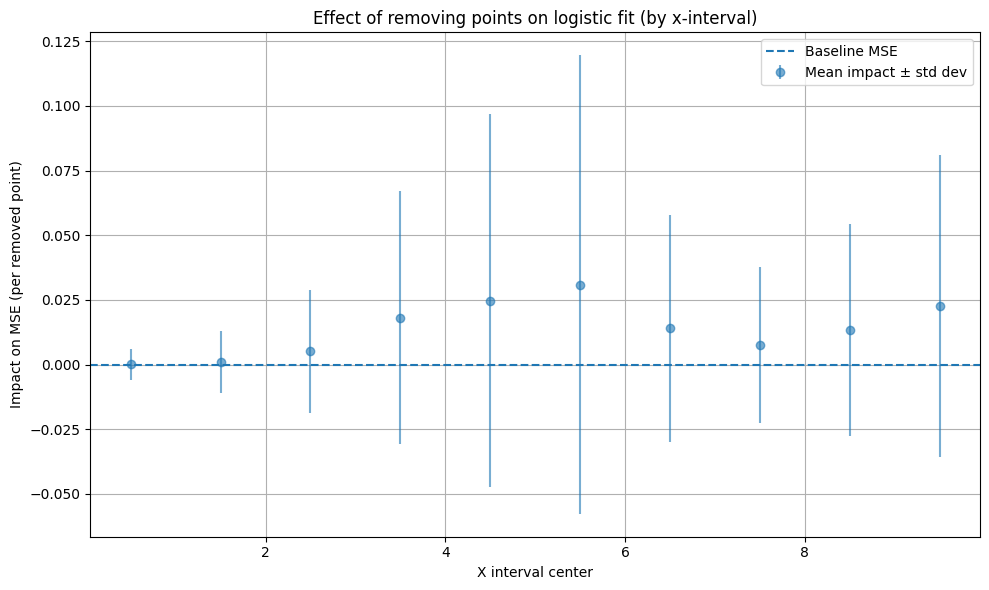

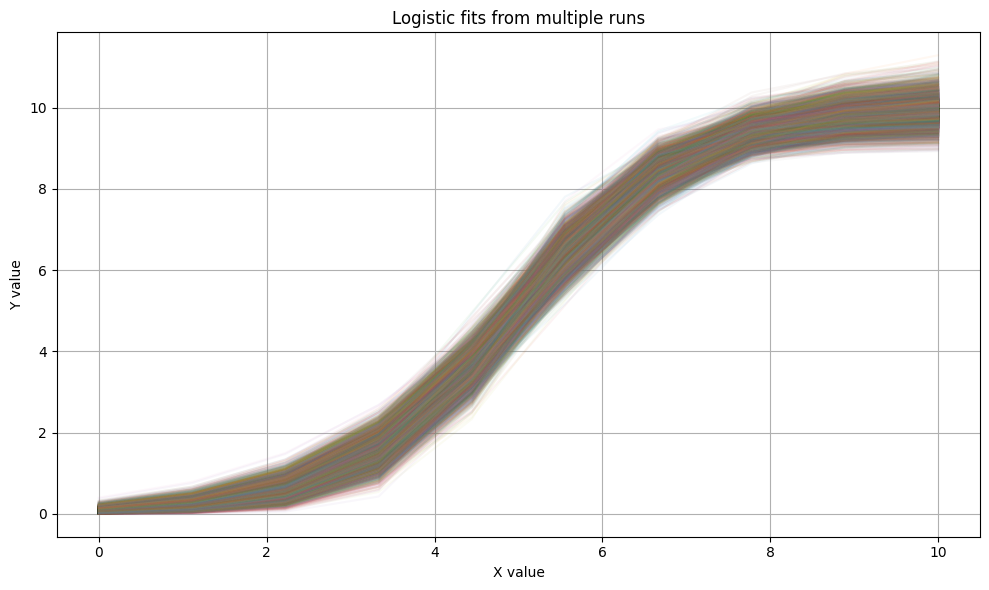

In [2]:

# ---------------------------------------------------------------------
# Example usage for point-removal analysis
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # Parameters for the point-removal analysis
    n_points = 10
    runs = 5000

    all_impacts, intervals = analyze_point_removal(n_points=n_points, runs=runs)

    # Aggregate results across runs
    mean_impacts = np.nanmean(all_impacts, axis=0)
    std_impacts = np.nanstd(all_impacts, axis=0)

    # Midpoints of intervals for plotting
    interval_centers = intervals[:-1] + 0.5 * (intervals[1] - intervals[0])

    # Plot the impact of point removal by interval
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        interval_centers,
        mean_impacts,
        yerr=std_impacts,
        fmt="o",
        alpha=0.6,
        label="Mean impact ± std dev",
    )
    plt.axhline(0, linestyle="--", label="Baseline MSE")
    plt.xlabel("X interval center")
    plt.ylabel("Impact on MSE (per removed point)")
    plt.title("Effect of removing points on logistic fit (by x-interval)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot fitted logistic functions for visualization (multiple runs)
    plt.figure(figsize=(10, 6))
    for _ in range(runs):
        x_values = np.linspace(0, 10, n_points)
        y_true = logistic_function(x_values, 10, 1, 5)
        y_values = y_true + 0.5 * np.random.normal(size=n_points)
        popt_initial, _ = curve_fit(
            logistic_function, x_values, y_values, p0=[10, 1, 5], maxfev=5000
        )
        y_fit_initial = logistic_function(x_values, *popt_initial)

        plt.plot(x_values, y_fit_initial, alpha=0.05)

    plt.xlabel("X value")
    plt.ylabel("Y value")
    plt.title("Logistic fits from multiple runs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Part 2 — Number of Points Required for a Stable Logistic Fit

Here we evaluate how many sampled points are necessary to obtain a stable and
reliable logistic fit. For each iteration:

1. A random number of points is sampled (between min_points and max_points)
2. A noisy logistic dataset is generated
3. The sigmoid is fitted
4. The MSE against the true curve is computed

We then study:

- Average MSE vs. number of points
- Probability of successful fits
- Number of extreme outliers
- Estimated stabilization point where adding more points stops improving accuracy


In [3]:

# ---------------------------------------------------------------------
# 2. Evaluation of fit stability vs. number of points
# ---------------------------------------------------------------------
def evaluate_fit_stability(
    L_true=10,
    k_true=1,
    x0_true=5,
    n_total=100,
    n_runs=20000,
    min_points=4,
    max_points=20,
    noise_level=0.6,
    max_mse=1e2,
):
    """
    Evaluates the number of data points needed to achieve a stable logistic fit.

    Parameters
    ----------
    L_true, k_true, x0_true : float
        True parameters of the logistic function.
    n_total : int
        Number of total x values in the underlying "true" grid.
    n_runs : int
        Number of Monte Carlo iterations.
    min_points, max_points : int
        Range of number of points used for fitting.
    noise_level : float
        Standard deviation of added noise.
    max_mse : float
        Maximum MSE value to keep; larger values are treated as extreme outliers
        and removed.

    Returns
    -------
    n_stable : int
        Recommended number of points needed to stabilize the error.
    """
    # Generate the true function values on a dense grid
    x_values = np.linspace(0, 10, n_total)
    y_true = logistic_function(x_values, L_true, k_true, x0_true)

    # Store results
    mse_results = []
    fit_counts = {n: 0 for n in range(min_points, max_points + 1)}  # successful fits
    total_counts = {n: 0 for n in range(min_points, max_points + 1)}  # total attempts
    removed_mse_counts = {n: 0 for n in range(min_points, max_points + 1)}  # removed outliers

    # Monte Carlo simulation
    for _ in range(n_runs):
        n_sample = np.random.randint(min_points, max_points + 1)
        indices = np.random.choice(n_total, n_sample, replace=False)
        x_sample = x_values[indices]
        y_sample = y_true[indices] + noise_level * np.random.normal(size=n_sample)

        total_counts[n_sample] += 1

        try:
            # Fit logistic function
            popt, _ = curve_fit(
                logistic_function,
                x_sample,
                y_sample,
                p0=[L_true, k_true, x0_true],
                maxfev=5000,
            )
            y_fit = logistic_function(x_values, *popt)
            mse = mean_squared_error(y_true, y_fit)

            if not np.isnan(mse):
                if mse < max_mse:
                    mse_results.append((n_sample, mse))
                    fit_counts[n_sample] += 1
                else:
                    removed_mse_counts[n_sample] += 1

        except RuntimeError:
            # Ignore failed fits
            pass

    # Convert results to DataFrame
    df_results = pd.DataFrame(mse_results, columns=["n_points", "mse"])

    if df_results.empty:
        print("No valid fits found!")
        return None

    # Compute mean MSE per number of points
    mse_avg = df_results.groupby("n_points")["mse"].mean()

    # Identify stabilization point:
    # smallest n where the change in mean MSE between consecutive n is "small"
    mse_values = mse_avg.values
    diffs = np.abs(np.diff(mse_values))
    stabilization_threshold = 0.01 * np.nanmax(mse_values)  # 1% of max mean MSE

    stable_index = np.where(diffs < stabilization_threshold)[0]
    if len(stable_index) > 0:
        # +1 because diff is between i and i+1
        n_stable = mse_avg.index[stable_index[0] + 1]
    else:
        n_stable = max_points

    # Proportion of successful fits per n
    fit_proportions = {
        n: (fit_counts[n] / total_counts[n] if total_counts[n] > 0 else 0.0)
        for n in fit_counts.keys()
    }

    # ------------------- PLOTS -------------------

    # Plot 1: Mean MSE vs. number of points
    plt.figure(figsize=(8, 6))
    plt.plot(mse_avg.index, mse_avg.values, linewidth=2, label="Average MSE")
    plt.axvline(n_stable, linestyle="--", label=f"Stabilization ~ {n_stable} points")
    plt.xlabel("Number of points used")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Fit accuracy vs. number of points (logistic fit)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Proportion of successful fits
    plt.figure(figsize=(8, 6))
    plt.bar(list(fit_proportions.keys()), list(fit_proportions.values()), alpha=0.7)
    plt.xlabel("Number of points used")
    plt.ylabel("Proportion of successful fits")
    plt.title("Proportion of successful fits vs. number of points")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Count of removed extreme MSE values per number of points
    if any(removed_mse_counts.values()):
        plt.figure(figsize=(8, 6))
        plt.bar(
            list(removed_mse_counts.keys()),
            list(removed_mse_counts.values()),
            alpha=0.7,
        )
        plt.xlabel("Number of points used")
        plt.ylabel("Count of extreme MSEs removed")
        plt.title("Count of removed extreme MSEs vs. number of points used")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return n_stable


C:\Users\bonte\AppData\Local\Temp\ipykernel_16032\2446242795.py:60: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(
C:\Users\bonte\AppData\Local\Temp\ipykernel_16032\2446242795.py:60: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(
C:\Users\bonte\AppData\Local\Temp\ipykernel_16032\2446242795.py:60: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(
C:\Users\bonte\AppData\Local\Temp\ipykernel_16032\2446242795.py:60: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(
C:\Users\bonte\AppData\Local\Temp\ipykernel_16032\3609704540.py:17: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\bonte\AppData\Local\Temp\ipykernel_16032\2446242795.py:60: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(
C:\Users\bonte\AppData\Local\Temp\ipykernel_160

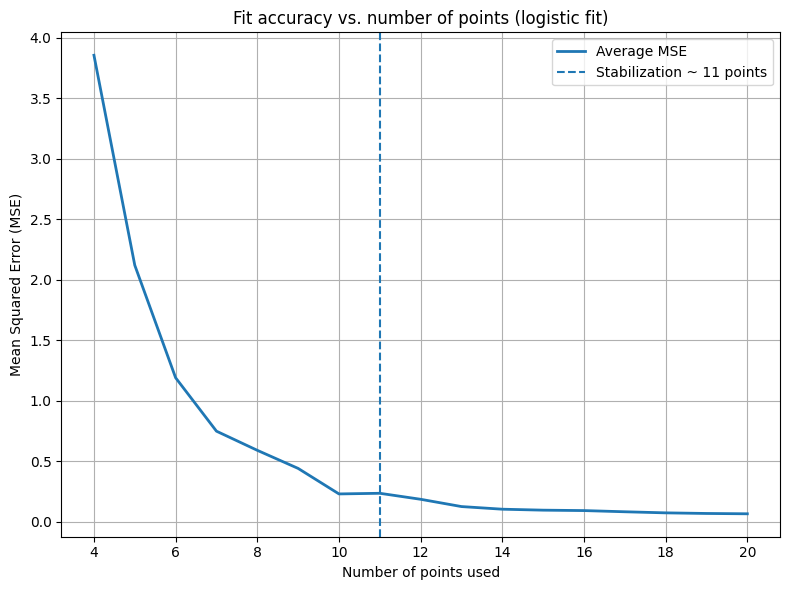

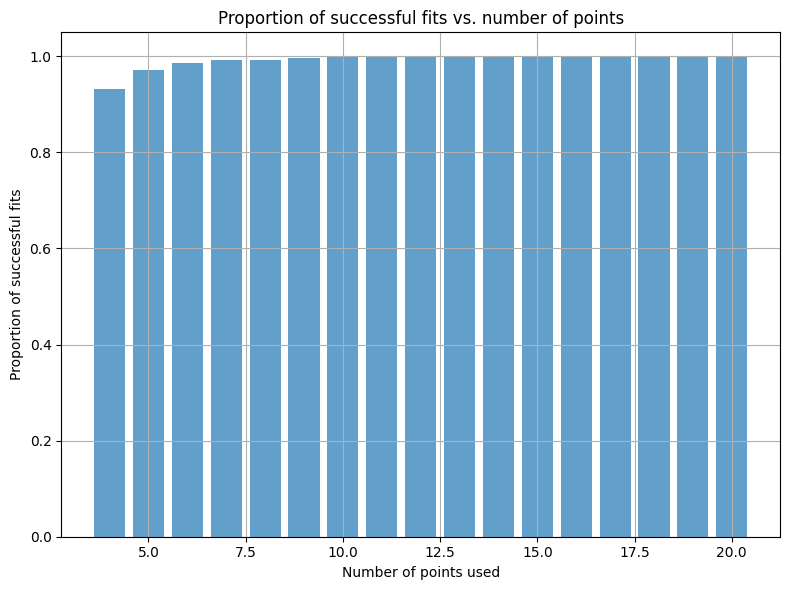

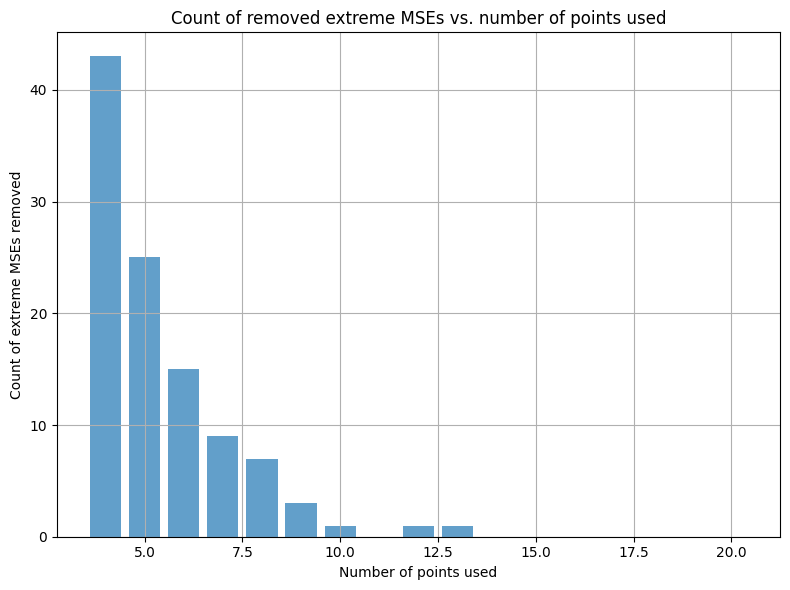

Recommended number of points (stabilization): 11


In [4]:
# ---------------------------------------------------------------------
# Example usage for fit-stability evaluation
# ---------------------------------------------------------------------
if __name__ == "__main__":
    recommended_points = evaluate_fit_stability()
    print(f"Recommended number of points (stabilization): {recommended_points}")
